<a href="https://colab.research.google.com/github/Tstorwick/QC-Mentorship/blob/master/QuantumMentorship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Mentorship Task 2
Thomas Storwick,
<br>
BASc Nanotechnology Engineering.
<br>
MASc Candidate, Nanotechnology Engineering

Installs and imports.<br>
Sometimes you need to re-start the runtime after you install cirq.

In [2]:
!pip install cirq

In [0]:
import cirq
import numpy as np
import matplotlib
from cirq.contrib.svg import circuit_to_svg
from IPython.display import SVG, display
import os

### Functions
Here we define the functions we are going to use throughout the problem. `updateCircuit` takes our parameters and outputs a new circuit with those parameters. `loss` is our loss function, which calculates how far we are from the desired state. `cprint` is a quick function that prints us a nicer version of the circuit diagram.  

In [0]:
def updateCircuit(thetaX, thetaY):
  circuitGates=[
          cirq.rx(thetaX * np.pi)(qubits[0]),
          cirq.ry(thetaY * np.pi)(qubits[0]),
          cirq.CNOT(control=qubits[0], target = qubits[1]),
          #add some noise
          cirq.depolarize(0.005)(qubits[0]),
          cirq.depolarize(0.005)(qubits[1]),
          cirq.measure(qubits[0],qubits[1])
  ]
  circuit=cirq.Circuit(*circuitGates)
  #circuit=circuit.with_noise(cirq.depolarize(0.01))
  return circuit

def cprint(circuit):
  """Convert the cirq.Circuit to a temp svg and display + garbage collect."""
  with open("temp.svg", 'w+') as f:
    f.write(circuit_to_svg(circuit))
  display(SVG('temp.svg'))
  os.remove('temp.svg')

def loss(probs):
  targetProbs=[0.5,0,0,0.5]
  loss=0
  loss+=np.abs(targetProbs[0]-probs[0])
  loss+=np.abs(targetProbs[3]-probs[3])
  return loss

Finally, we make the qubits we will be running all our circuits on.

In [0]:
qubits = cirq.LineQubit.range(2)

## Simple Gradient Decent
Here, we implement a simple gradient decent that moves both Rx and Ry and the same time.

### Initialize
Here we set our initial guess values, `thetas`, our learning rate `delta`, the number of times we run each itteration of the circuit `reps`, and the finall error tolerance in our answer `errorTol`.

In [0]:
thetas=[0.,0.] #[X,Y]
delta=0.05
reps=1000
errorTol=0.1

Initial state: 

Setup the circuit and run it once to get our initial "guess" value.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


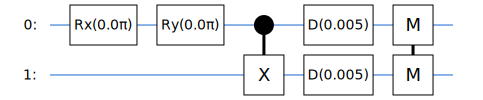

[[0.0, 0.0], [0.995, 0.004, 0.001, 0.0], 0.995]


In [7]:
circuit=updateCircuit(thetas[0],thetas[1])
cprint(circuit)
probs=[]
#initial state
result=cirq.sample(circuit, repetitions=reps).histogram(key='0,1')
for i in range(4):
  probs.append(result[i]/reps)
results=[[thetas,probs,loss(probs)]]
run=0
print(results[0])

Make 1 exploritory move in the space by delta. This sets up our space so that we can use these two points to aproximate a derivitive. 

In [0]:
thetas=[theta+delta for theta in thetas]
circuit=updateCircuit(thetas[0],thetas[1])
result=cirq.sample(circuit, repetitions=reps).histogram(key='0,1')
probs=[]
for i in range(4):
  probs.append(result[i]/reps)
results.append([thetas,probs,loss(probs)])
run+=1

[[[0.0, 0.0], [0.995, 0.004, 0.001, 0.0], 0.995], [[0.05, 0.05], [0.98, 0.003, 0.003, 0.014], 0.966]]


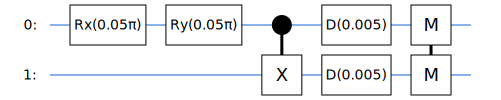

In [9]:
print(results)
cprint(circuit)

### Descend!
Finally, we run our gradient decent problem to find some thetas that satifiy our error tolerance. This is the simplest itteration of this problem. Since we know beforehand that the solution is both angles should be pi/2, we can step through both angles in each step at the same time. This wont work for all problems of this type (given some gates find the paramters that give a particular solution) but will work for this one. We will update this later on. 

In [10]:
while True:
  #thetas=[theta-4*(results[run][2]-results[run-1][2]) for theta in thetas]
  thetas=[thetas[i]-delta*(results[run][2]-results[run-1][2])/(results[run][0][i]-results[run-1][0][i]) for i in range(len(thetas))]
  circuit=updateCircuit(thetas[0],thetas[1])
  result=cirq.sample(circuit, repetitions=reps).histogram(key='0,1')
  probs=[]
  for i in range(4):
    probs.append(result[i]/reps)
  results.append([thetas,probs,loss(probs)])
  run+=1
  print("Qubits: "+ str(results[run][0])+". Loss: " + str(results[run][2])+"  Probs: "+str(results[run][1]))
  if results[run][2]<errorTol:
    break
  elif run>1000:
    break

print(results[run])


Qubits: [0.07900000000000003, 0.07900000000000003]. Loss: 0.944  Probs: [0.97, 0.002, 0.002, 0.026]
Qubits: [0.11693103448275866, 0.11693103448275866]. Loss: 0.8740000000000001  Probs: [0.935, 0.001, 0.003, 0.061]
Qubits: [0.20920376175548572, 0.20920376175548572]. Loss: 0.611  Probs: [0.801, 0.003, 0.006, 0.19]
Qubits: [0.35171607702642205, 0.35171607702642205]. Loss: 0.176  Probs: [0.585, 0.003, 0.003, 0.409]
Qubits: [0.504334466241769, 0.504334466241769]. Loss: 0.02200000000000002  Probs: [0.484, 0.004, 0.006, 0.506]
[[0.504334466241769, 0.504334466241769], [0.484, 0.004, 0.006, 0.506], 0.02200000000000002]


# Implementing a Jiggle
The above code works reasonably well, but after running it a couple of times with different learning rates and `reps`, a major flaw becomes clear (aside from steping X and Y at the same time). Our simple gradient decent algorithim works like this 
<br>
$ \theta_{n+1} = \theta_n - \lambda(\frac{\partial f(\theta)}{\partial \theta})_{\theta = \theta_n} $
<br> 
Where $f$ is our loss function (defined as `loss` in this code), which is a function of the circuit we are trying to learn, and for some learning rate $\lambda$. Now, we dont know $\frac{\partial f(\theta)}{\partial \theta}$, so we will be aproximating it with the first order numerical derivitive (the backwards difference in this case).: 
<br>
$\frac{\partial f(\theta)}{\partial \theta} = \frac{f(\theta_n)-f(\theta_{n-1})}{\theta_n - \theta_{n-1}}$
<br>
We could use a more complex aproximation, but this works well enough for our purposes.
<br>
Finally, our total decent algorithm is:
<br> 
$ \theta_{n+1} = \theta_n - \lambda(\frac{f(\theta_n)-f(\theta_{n-1})}{\theta_n - \theta_{n-1}})$
<br>
This works very well if we live in a classical, and/or deterministic world. The issue comes about because our loss fuction isnt directly a property of the circuit - its dependent on the output of the circuit measurements, which are probabilisitc. At the very start of the algorithim, a change in theta causes a small change in the probabiltiy of measureing the |11> state. If the number of `runs` is small, it is likely that this change will not be seen. Our algorithim then thinks the function in flat, doesnt move our theta, and on the next itteration the program throws an error. We could get around this buy running our quantum circuit many times but lets assume our quantum hardware is costly to set-up, and we want to run it as few times as possible. 

To get around this, I've implemented what I call a `jiggle`. If our algorithim says that theta shouldnt move, but the error condition is not met, then we apply a small increment to theta to keep the algorithim moving. This `jiggle` should be small enough that if we move our theta in the wrong direction, the derivitive can correct for it and get our theta moving in the right direction.

In [0]:
thetas=[0.,0.] #[X,Y]
delta=0.003
jiggle=0.01
reps=50
errorTol=0.01

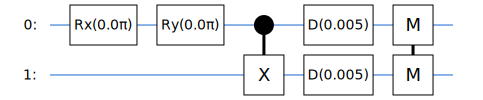

[[0.0, 0.0], [1.0, 0.0, 0.0, 0.0], 1.0]


In [12]:
circuit=updateCircuit(thetas[0],thetas[1])
cprint(circuit)
probs=[]
#initial state
result=cirq.sample(circuit, repetitions=reps).histogram(key='0,1')
for i in range(4):
  probs.append(result[i]/reps)
results=[[thetas,probs,loss(probs)]]
run=0
print(results[0])

In [0]:
thetas=[theta+delta for theta in thetas]
circuit=updateCircuit(thetas[0],thetas[1])
result=cirq.sample(circuit, repetitions=reps).histogram(key='0,1')
probs=[]
for i in range(4):
  probs.append(result[i]/reps)
results.append([thetas,probs,loss(probs)])
run+=1

In [14]:
print(results)

[[[0.0, 0.0], [1.0, 0.0, 0.0, 0.0], 1.0], [[0.003, 0.003], [1.0, 0.0, 0.0, 0.0], 1.0]]


In [15]:
while True:
  #thetas=[theta-4*(results[run][2]-results[run-1][2]) for theta in thetas]
  if np.abs(results[run][0][0]-results[run-1][0][0])>0:
    thetas=[thetas[i]-delta*(results[run][2]-results[run-1][2])/(results[run][0][i]-results[run-1][0][i]) for i in range(len(thetas))]
  else:
    thetas=[theta+jiggle for theta in thetas]
    print("jiggled")
  circuit=updateCircuit(thetas[0],thetas[1])
  result=cirq.sample(circuit, repetitions=reps).histogram(key='0,1')
  probs=[]
  for i in range(4):
    probs.append(result[i]/reps)
  results.append([thetas,probs,loss(probs)])
  run+=1
  print("Qubits: "+ str(results[run][0])+". Loss: " + str(results[run][2])+"  Probs: "+str(results[run][1]))
  if results[run][2]<errorTol:
    break
  elif run>200:
    print("Timeout")
    break


Qubits: [0.003, 0.003]. Loss: 1.0  Probs: [1.0, 0.0, 0.0, 0.0]
jiggled
Qubits: [0.013000000000000001, 0.013000000000000001]. Loss: 1.0  Probs: [1.0, 0.0, 0.0, 0.0]
Qubits: [0.013000000000000001, 0.013000000000000001]. Loss: 1.0  Probs: [1.0, 0.0, 0.0, 0.0]
jiggled
Qubits: [0.023, 0.023]. Loss: 0.98  Probs: [0.98, 0.02, 0.0, 0.0]
Qubits: [0.029000000000000005, 0.029000000000000005]. Loss: 0.98  Probs: [0.98, 0.0, 0.02, 0.0]
Qubits: [0.029000000000000005, 0.029000000000000005]. Loss: 1.0  Probs: [1.0, 0.0, 0.0, 0.0]
jiggled
Qubits: [0.03900000000000001, 0.03900000000000001]. Loss: 0.98  Probs: [0.98, 0.02, 0.0, 0.0]
Qubits: [0.04500000000000001, 0.04500000000000001]. Loss: 1.0  Probs: [1.0, 0.0, 0.0, 0.0]
Qubits: [0.03500000000000001, 0.03500000000000001]. Loss: 0.96  Probs: [0.98, 0.0, 0.0, 0.02]
Qubits: [0.023, 0.023]. Loss: 1.0  Probs: [1.0, 0.0, 0.0, 0.0]
Qubits: [0.033, 0.033]. Loss: 0.98  Probs: [0.98, 0.02, 0.0, 0.0]
Qubits: [0.03900000000000001, 0.03900000000000001]. Loss: 0.98  

## Expanding on the jiggle

The jiggle seems to have solved our initial problem! But we have found another problem. For experiments with higher learning rates (rate~=0.01), and lower number of `reps` (aprox. 100), our thetas seem to move smoothly, and the suddently jump to a wildly different value.

What happens is sometimes, our theta will move by a small amount, implying a small change in the function; however, randomly, sometimes the function changes a lot due to the random nature of the quantum computing, not because of a large change in theta. This causes a large random jump around the problem space. 

In theory, implementing a higher order aproximation of our derivitive could help with this. With a second or third order aproximation, we could take into account more of the information around our point and mitigate the effect of a random large variation.

Alternativly, we could set a minimum step size (basically our jiggle), and or a maximum step size. If we set a minimum, we don't want our function to move in large jumps as it reaches the solution, so it makes sense to make this miniumum step size decrease with the itteration number. On the other hand, for a maximum step size, we would do same thing, to cap the movement of our thetas as we get closer to the solution. This follows a simliar logic to simulated anealing, but in this case the large jumping exploration of the state space is driven by the quantum system itself, not the algorithim. 

Finally, as a easy to implement option, we could set guidelines/limits on what our learning rate `delta`, could be for a given number circuit queries `reps`. This makes the weighting of the derivitive small enough that the probabilistic jumps are mitigated. In practice $ delta = 0.00005*reps$ works well. The issue here is that as we aproach a small number of `reps`, our delta is very small, and we invoke the jiggle frequently. 

# Separating X and Y
The previous algorithim worked well to explore how gradient descent works in this case, but for a proper implimentation we should sepearate the effect of rotations in x, and rotations in y. I've also cleaned up the code a little.

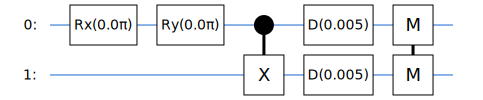

[[[0.0, 0.0], [0.994, 0.002, 0.004, 0.0], 0.994]]
run: 4, Qubits: [-0.019000000000000017, 0.001]. Loss: 0.992  Probs: [0.994, 0.001, 0.003, 0.002]
run: 5, Qubits: [-0.019000000000000017, -0.009000000000000008]. Loss: 0.99  Probs: [0.993, 0.001, 0.003, 0.003]
run: 6, Qubits: [-0.021500000000000016, -0.009000000000000008]. Loss: 0.995  Probs: [0.995, 0.005, 0.0, 0.0]
run: 7, Qubits: [-0.021500000000000016, -0.011000000000000008]. Loss: 0.99  Probs: [0.993, 0.003, 0.001, 0.003]
run: 8, Qubits: [-0.0014999999999999875, -0.011000000000000008]. Loss: 0.988  Probs: [0.989, 0.002, 0.008, 0.001]
run: 9, Qubits: [-0.0014999999999999875, -0.03600000000000003]. Loss: 0.991  Probs: [0.992, 0.004, 0.003, 0.001]
run: 10, Qubits: [-0.0004999999999999879, -0.03600000000000003]. Loss: 0.982  Probs: [0.986, 0.007, 0.003, 0.004]
run: 11, Qubits: [-0.0004999999999999879, -0.03480000000000003]. Loss: 0.988  Probs: [0.991, 0.002, 0.004, 0.003]
run: 12, Qubits: [0.08950000000000014, -0.03480000000000003]. Los

In [16]:
thetas=[0.,0.] #[X,Y]
delta=0.01
jiggle=0.001
reps=1000
errorTol=0.01

#setup
circuit=updateCircuit(thetas[0],thetas[1])
cprint(circuit)
probs=[]

#initial state
result=cirq.sample(circuit, repetitions=reps).histogram(key='0,1')
for i in range(4):
  probs.append(result[i]/reps)
results=[[[thetas[0],thetas[1]],probs,loss(probs)]]
print(results)

#initial X
thetas[0]=thetas[0]+jiggle
circuit=updateCircuit(thetas[0],thetas[1])
result=cirq.sample(circuit, repetitions=reps).histogram(key='0,1')
probs=[]

for i in range(4):
  probs.append(result[i]/reps)
results.append([[thetas[0],thetas[1]],probs,loss(probs)]) # [thetas[0],thetas[1]] instead of thetas because of a weird python issue where it keeps pointing to the var thetas instead of taking its values

if np.abs(results[-1][0][0]-results[-2][0][0])>0:
  updateX=-delta*(results[-1][2]-results[-2][2])/(results[-1][0][0]-results[-2][0][0])
else:
  updateX=jiggle

#initial Y
thetas[1]=thetas[1]+jiggle
circuit=updateCircuit(thetas[0],thetas[1])
result=cirq.sample(circuit, repetitions=reps).histogram(key='0,1')
probs=[]

for i in range(4):
  probs.append(result[i]/reps)
results.append([[thetas[0],thetas[1]],probs,loss(probs)])

if np.abs(results[-1][0][1]-results[-2][0][1])>0:
  updateY=-delta*(results[-1][2]-results[-2][2])/(results[-1][0][1]-results[-2][0][1])
else:
  updateY=jiggle


while True:
  #step in X
  thetas[0]=thetas[0]+updateX
  circuit=updateCircuit(thetas[0],thetas[1])
  result=cirq.sample(circuit, repetitions=reps).histogram(key='0,1')

  probs=[]
  for i in range(4):
    probs.append(result[i]/reps)
  results.append([[thetas[0],thetas[1]],probs,loss(probs)])

  print("run: "+str(len(results))+", Qubits: "+ str(results[-1][0])+". Loss: " + str(results[-1][2])+"  Probs: "+str(results[-1][1]))
  if np.abs(results[-1][0][0]-results[-2][0][0])>0:
    updateX=-delta*(results[-1][2]-results[-2][2])/(results[-1][0][0]-results[-2][0][0])
  else:
    updateX=jiggle
    print("will jiggle X")
  if results[-1][2]<errorTol:
    break 

  
  #step in Y
  thetas[1]=thetas[1]+updateY
  circuit=updateCircuit(thetas[0],thetas[1])
  result=cirq.sample(circuit, repetitions=reps).histogram(key='0,1')
  probs=[]
  for i in range(4):
    probs.append(result[i]/reps)
  results.append([[thetas[0],thetas[1]],probs,loss(probs)])
  print("run: "+str(len(results))+", Qubits: "+ str(results[-1][0])+". Loss: " + str(results[-1][2])+"  Probs: "+str(results[-1][1]))
  if np.abs(results[-1][0][1]-results[-2][0][1])>0:
    updateY=-delta*(results[-1][2]-results[-2][2])/(results[-1][0][1]-results[-2][0][1])
  else:
    updateY=jiggle
    print("will jiggle Y")
  if results[-1][2]<errorTol:
    break 



Now with random thetas:

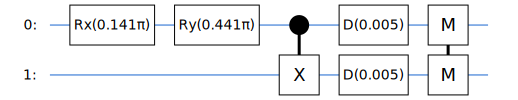

[[[0.14068455204466646, 0.4411494417192061], [0.5792, 0.0035, 0.0036, 0.4137], 0.16550000000000004]]
run: 4, Qubits: [0.4116845520446698, 0.4421494417192061]. Loss: 0.032399999999999984  Probs: [0.5134, 0.0023, 0.0033, 0.481]
run: 5, Qubits: [0.4116845520446698, -1.6178505582807872]. Loss: 0.09820000000000007  Probs: [0.546, 0.0034, 0.0028, 0.4478]
run: 6, Qubits: [0.467610477970595, -1.6178505582807872]. Loss: 0.03370000000000006  Probs: [0.5137, 0.0028, 0.0035, 0.48]
run: 7, Qubits: [0.467610477970595, -1.6146563835235055]. Loss: 0.028500000000000025  Probs: [0.5108, 0.0031, 0.0038, 0.4823]
run: 8, Qubits: [0.5829416037984111, -1.6146563835235055]. Loss: 0.06849999999999995  Probs: [0.4621, 0.0029, 0.0044, 0.5306]
run: 9, Qubits: [0.5829416037984111, -1.4518600309399239]. Loss: 0.043899999999999995  Probs: [0.5181, 0.0041, 0.0036, 0.4742]
run: 10, Qubits: [0.5482588590381474, -1.4518600309399239]. Loss: 0.010099999999999998  Probs: [0.5018, 0.0034, 0.0031, 0.4917]
run: 11, Qubits: [0

In [17]:
thetas=[np.random.random(),np.random.random()] #[X,Y]
delta=0.1
jiggle=0.001
reps=10000
errorTol=0.01

#setup
circuit=updateCircuit(thetas[0],thetas[1])
cprint(circuit)
probs=[]

#initial state
result=cirq.sample(circuit, repetitions=reps).histogram(key='0,1')
for i in range(4):
  probs.append(result[i]/reps)
results=[[[thetas[0],thetas[1]],probs,loss(probs)]]
print(results)

#initial X
thetas[0]=thetas[0]+jiggle
circuit=updateCircuit(thetas[0],thetas[1])
result=cirq.sample(circuit, repetitions=reps).histogram(key='0,1')
probs=[]

for i in range(4):
  probs.append(result[i]/reps)
results.append([[thetas[0],thetas[1]],probs,loss(probs)]) # [thetas[0],thetas[1]] instead of thetas because of a weird python issue where it keeps pointing to the var thetas instead of taking its values

if np.abs(results[-1][0][0]-results[-2][0][0])>0:
  updateX=-delta*(results[-1][2]-results[-2][2])/(results[-1][0][0]-results[-2][0][0])
else:
  updateX=jiggle

#initial Y
thetas[1]=thetas[1]+jiggle
circuit=updateCircuit(thetas[0],thetas[1])
result=cirq.sample(circuit, repetitions=reps).histogram(key='0,1')
probs=[]

for i in range(4):
  probs.append(result[i]/reps)
results.append([[thetas[0],thetas[1]],probs,loss(probs)])

if np.abs(results[-1][0][1]-results[-2][0][1])>0:
  updateY=-delta*(results[-1][2]-results[-2][2])/(results[-1][0][1]-results[-2][0][1])
else:
  updateY=jiggle


while True:
  #step in X
  thetas[0]=thetas[0]+updateX
  circuit=updateCircuit(thetas[0],thetas[1])
  result=cirq.sample(circuit, repetitions=reps).histogram(key='0,1')

  probs=[]
  for i in range(4):
    probs.append(result[i]/reps)
  results.append([[thetas[0],thetas[1]],probs,loss(probs)])

  print("run: "+str(len(results))+", Qubits: "+ str(results[-1][0])+". Loss: " + str(results[-1][2])+"  Probs: "+str(results[-1][1]))
  if np.abs(results[-1][0][0]-results[-2][0][0])>0:
    updateX=-delta*(results[-1][2]-results[-2][2])/(results[-1][0][0]-results[-2][0][0])
  else:
    updateX=jiggle
    print("will jiggle X")
  if results[-1][2]<errorTol:
    break 

  
  #step in Y
  thetas[1]=thetas[1]+updateY
  circuit=updateCircuit(thetas[0],thetas[1])
  result=cirq.sample(circuit, repetitions=reps).histogram(key='0,1')
  probs=[]
  for i in range(4):
    probs.append(result[i]/reps)
  results.append([[thetas[0],thetas[1]],probs,loss(probs)])
  print("run: "+str(len(results))+", Qubits: "+ str(results[-1][0])+". Loss: " + str(results[-1][2])+"  Probs: "+str(results[-1][1]))
  if np.abs(results[-1][0][1]-results[-2][0][1])>0:
    updateY=-delta*(results[-1][2]-results[-2][2])/(results[-1][0][1]-results[-2][0][1])
  else:
    updateY=jiggle
    print("will jiggle Y")
  if results[-1][2]<errorTol:
    break 

